In [1]:
import nengo
import nengolib
import numpy as np
%pylab inline
import pylab
from nengo.utils.matplotlib import rasterplot
import matplotlib.collections as mcol
from mpl_toolkits.axes_grid.inset_locator import inset_axes

%run ../dashedlines.py
%run ../UTC.py
%run ../UTC_prospective.py

Populating the interactive namespace from numpy and matplotlib


/var/folders/tz/8tnj8bnd0gjcvxwkzlnskql00000gn/T/ipykernel_60991/137173203.py:8: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes


# Prospective Timing Demo

## Motor Timing

### Generating thresholds for motor timing

In [2]:
%%capture

traces = []
thresholds = []
for d in np.arange(1, 11):
    with nengo.Network() as network:
        step_input = nengo.Node(output=1)
        rw = nengolib.networks.RollingWindow(neuron_type=nengo.Direct(),
                                             n_neurons = 100,
                                             theta = 1,
                                             dimensions=d,
                                             process=None,
                                             legendre=True,
                                             realizer=nengolib.signal.realizers.Identity())
        nengo.Connection(step_input, rw.input)
        
        p_rw = nengo.Probe(rw.state, synapse=None)
        
    with nengo.Simulator(network) as sim:
        sim.run(1.5)
        
        traces.append(sim.data[p_rw][:, 0])
        thresholds.append(sim.data[p_rw][1000,0])



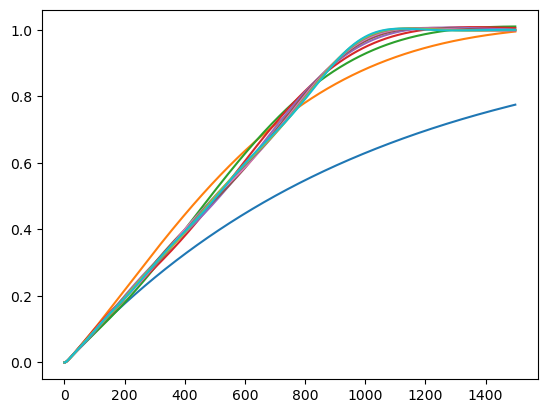

In [3]:
for d in np.arange(0, 10):
    plt.plot(traces[d])

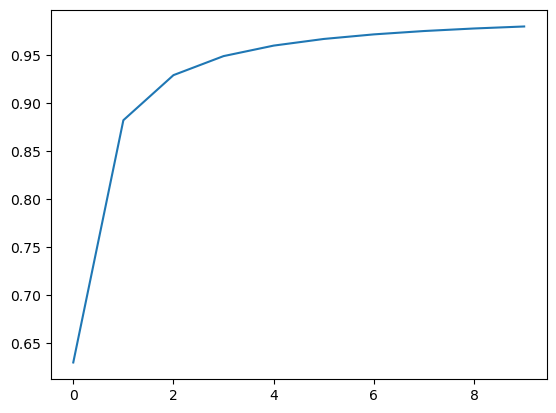

In [4]:
plt.plot(thresholds)

In [5]:
thresholds

[0.6300808623772144,
 0.8821421244327541,
 0.9290490234086628,
 0.9488498184225514,
 0.95977315316898,
 0.9666894084290003,
 0.971456435734072,
 0.9749375194262625,
 0.9775884384594873,
 0.9796725204244149]

In [6]:
%%capture
n_trials = 1
# 'normally' spaced control 
control = scipy.stats.norm.ppf(np.linspace(0.1, 0.9, 21), 1, 0.3) 
trial = 0

for c in control:
    UTC_prospective().run(task_type='prospective_motor',
                         prestim=0.,
                         dimensions=1,
                         verbose=False,
                         seed=trial,
                         effective_theta=None,
                         c=c,
                         full_output=True,
                         between_gain_noise_std=0,
                         within_gain_noise_std=0, 
                         input_noise_std=0,
                         data_dir = 'prospective_demo_motor')
    trial += 1

In [7]:
prospective_demo_motor_data = pytry.read('prospective_demo_motor')

In [8]:
prospective_demo_motor_dt = pd.DataFrame(prospective_demo_motor_data)

## Sensory timing

In [9]:
%%capture
n_trials = 1
# 'normally' spaced control 
control = scipy.stats.norm.ppf(np.linspace(0.1, 0.9, 21), 1, 0.3) 
trial = 0

for c in control:
    UTC_prospective().run(task_type='prospective_sensory',
                         prestim=0.,
                         poststim=0.,
                         dimensions=1,
                         verbose=False,
                         seed=trial,
                         effective_theta=None,
                         c=c,
                         trial_duration=1.,
                         full_output=True,
                         between_gain_noise_std=0,
                         within_gain_noise_std=0, 
                         input_noise_std=0,
                         data_dir = 'prospective_demo_sensory')
    trial += 1

In [10]:
prospective_demo_sensory_data = pytry.read('prospective_demo_sensory')

In [11]:
prospective_demo_sensory_dt = pd.DataFrame(prospective_demo_sensory_data)

### Plotting

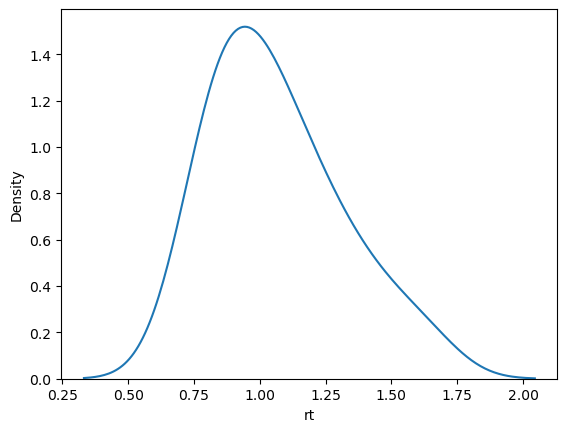

In [12]:
motor_density = sns.kdeplot(data = prospective_demo_motor_dt['rt']/1000).get_lines()[0].get_data()

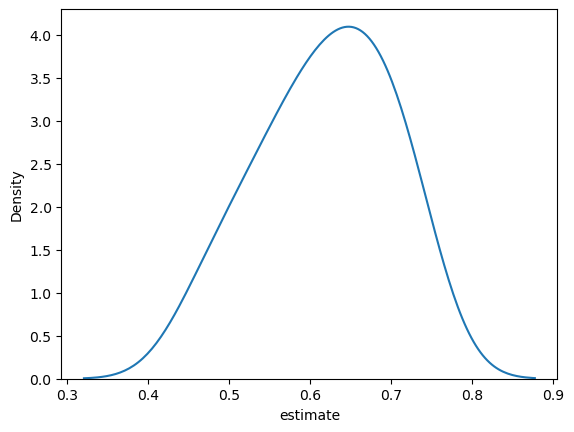

In [13]:
sensory_density = sns.kdeplot(data = prospective_demo_sensory_dt['estimate']).get_lines()[0].get_data()

[]

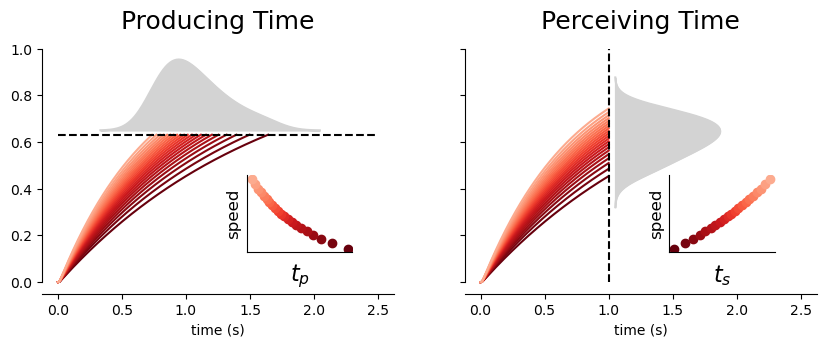

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10, 10/3))

colors = plt.cm.Reds(np.linspace(0.3, 1, len(control)))[::-1]

for i in range(0, len(control)):
    conditions = (prospective_demo_motor_dt['c']==control[i])
    rt = int(prospective_demo_motor_dt[conditions]['rt'].values[0])
    ax1.plot(prospective_demo_motor_dt[conditions]['time'].values[0][0:rt],
             prospective_demo_motor_dt[conditions]['readout'].values[0][0:rt], 
             color = colors[i])
    
ax1.plot(motor_density[0], (motor_density[1]/5)+0.65,
         color='lightgrey')
ax1.fill_between(motor_density[0], (motor_density[1]/5)+0.65, 0.65, 
                 color='lightgrey')

ax1.set_title('Producing Time', size=18)
ax1.set_xlabel('time (s)')
ax1.set_ylabel('', size=15, rotation=0)
ax1.yaxis.set_label_coords(-0.12, 0.5)
#ax1.text(-0.35, 1.1, 'A.', size=20)

ax1.spines['left'].set_bounds(low=0., high=1)
ax2.spines['left'].set_bounds(low=0., high=1)
ax1.set_yticks([0., 0.2, 0.4, 0.6, 0.8, 1.])
ax2.set_yticks([0., 0.2, 0.4, 0.6, 0.8, 1.])


#plt.xlabel('time (s)')
#plt.ylabel('state')

for i in range(0, len(control)):
    conditions = (prospective_demo_sensory_dt['c']==control[i])
    ax2.plot(prospective_demo_sensory_dt[conditions]['time'].values[0][0:1000],
             prospective_demo_sensory_dt[conditions]['readout'].values[0][0:1000], 
             color = colors[i])

ax2.plot((sensory_density[1]/5)+1.05, sensory_density[0],
         color='lightgrey')
plt.fill_betweenx(sensory_density[0], (sensory_density[1]/5)+1.05, 1.05, 
                  color='lightgrey')

ax2.set_title('Perceiving Time', size=18)
ax2.set_xlabel('time (s)')
#ax2.text(-0.35, 1.1, 'B.', size=20)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.subplots_adjust(hspace = .0001, wspace = .2)
ax1.hlines(y=prospective_demo_motor_dt['threshold'][0], ls='dashed', xmin=0, xmax=2.5, 
           color='black')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.tick_params(axis=u'y', which=u'both',length=0)

ax2.vlines(x=1., ls='dashed', ymin=0, ymax=1., color='black')

# motor timing theta plot
speed_ax1 = inset_axes(ax1, width="30%", height="30%", loc=4, borderpad=3)
for i in range(0, len(control)):
    conditions = (prospective_demo_motor_dt['c']==control[i])
    speed_ax1.scatter(prospective_demo_motor_dt[conditions]['rt'].values[0],
             prospective_demo_motor_dt[conditions]['control'].values[0], 
             color = colors[i], lw=1)


#plt.loglog()
speed_ax1.set_xlabel(r'$t_{p}$', size=16)
speed_ax1.set_ylabel(r'speed', size=12, rotation=90)
speed_ax1.yaxis.set_label_coords(-0.05, 0.5)
speed_ax1.spines['top'].set_visible(False)
speed_ax1.spines['right'].set_visible(False)

speed_ax1.set_xticks([])
speed_ax1.set_yticks([])

# sensory timing
speed_ax2 = inset_axes(ax2, width="30%", height="30%", loc=4, borderpad=3)
for i in range(0, len(control)):
    conditions = (prospective_demo_sensory_dt['c']==control[i])
    speed_ax2.scatter(prospective_demo_sensory_dt[conditions]['estimate'].values[0],
             prospective_demo_sensory_dt[conditions]['control'].values[0], 
             color = colors[i], lw=1)
    
    
speed_ax2.set_xlabel(r'$t_{s}$', size=16)
speed_ax2.set_ylabel(r'speed', size=12, rotation=90)
speed_ax2.yaxis.set_label_coords(-0.05, 0.5)
speed_ax2.spines['top'].set_visible(False)
speed_ax2.spines['right'].set_visible(False)

speed_ax2.set_xticks([])
speed_ax2.set_yticks([])

#plt.savefig('prospective_demo.png', bbox_inches='tight', dpi=600)
#fig.savefig('prospective_demo.tiff', dpi=1000, bbox_inches='tight')


### Why window size matters


In [15]:
plt.rcParams['lines.marker'] = ''
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.handlelength'] = 3


In [16]:
%%capture
#n_trials = 1
trial = 0
control = np.array([0.1, 1, 10])
                   
for c in control:
    UTC_prospective().run(task_type='prospective_sensory',
                         prestim=0.,
                         trial_duration=10,
                         dimensions=1,
                         verbose=False,
                         seed=trial,
                         effective_theta=None,
                         c=c,
                         full_output=True,
                         between_gain_noise_std=0,
                         within_gain_noise_std=3, 
                         input_noise_std=0,
                         data_dir = 'prospective_demo_theta')
    trial += 1

In [17]:
prospective_demo_theta_data = pytry.read('prospective_demo_theta')

In [18]:
prospective_demo_theta_dt = pd.DataFrame(prospective_demo_theta_data)

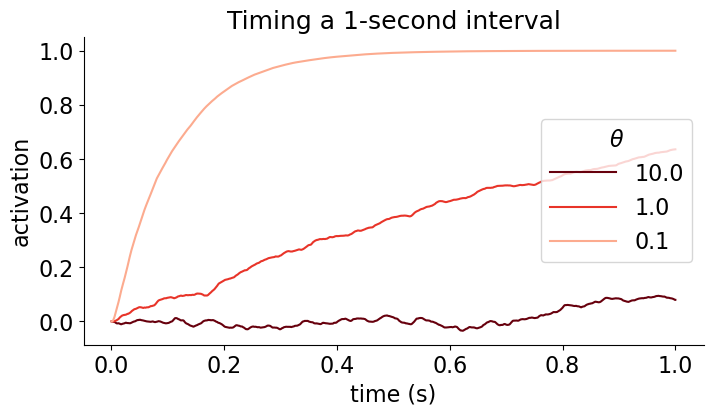

In [19]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
plt.rcParams['legend.title_fontsize'] = 16

colors = plt.cm.Reds(np.linspace(0.3, 1, len(control)))[::-1]

for i in range(0, len(control)):
    conditions = (prospective_demo_theta_dt['c']==control[i])
    ax1.plot(prospective_demo_theta_dt[conditions]['time'].values[0][0:1000],
             prospective_demo_theta_dt[conditions]['state'].values[0][0:1000, 0], 
             color = colors[i], label='{}'.format(1/control[i]))

ax1.set_title('Timing a 1-second interval', size=18)
ax1.set_xlabel('time (s)', size=16)
ax1.set_ylabel('activation', size=16, rotation=90)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.legend(title=r'$\theta$', fontsize=16, loc='right')
#ax1.yaxis.set_label_coords(-0.12, 0.5)

#plt.savefig('prospective_demo_theta.png', bbox_inches='tight', dpi=600)